<a href="https://colab.research.google.com/github/AlexeyEvzrezov/deep-learning/blob/main/simpsons_characters_classification/simpsons_characters_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simpsons' Characters Classification

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, sampler

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

from efficientnet_pytorch import EfficientNet

import PIL
from PIL import Image

from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import time
import os
import copy
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
if torch.cuda.is_available():
    print('CUDA is available!  Training on GPU ...')    
else:
    print('CUDA is not available.  Training on CPU ...')    

CUDA is available!  Training on GPU ...


# Data and Global Variables

In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/journey-springfield.zip 

In [ ]:
TRAIN_DIR = Path('./train/simpsons_dataset')
TEST_DIR = Path('./testset/testset')
MODELS_DIR = '/content/drive/MyDrive/Colab_Notebooks'

In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device('cuda')
BATCH_SIZE = 32

# Classes and Functions

## Data Generation

In [ ]:
class ImgDataGenerator(Dataset):

    def __init__(self, files, transforms_data, mode):
        self.files = files
        self.transforms_data = transforms_data
        self.mode = mode

        self.modes = ['train', 'val', 'test']

        if self.mode not in self.modes:
            print(f'{self.mode} is not correct; correct modes: {self.modes}')
            raise NameError

        self.label_encoder = LabelEncoder()    

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]            
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = Image.open(self.files[idx])
        image = self.transforms_data(image)

        if self.mode == 'test':
            return image
        else:
            label = self.labels[idx]
            label_id = self.label_encoder.transform([label]).item()
            return image, label_id

## Resampling

In [ ]:
class ImbSampler(sampler.Sampler):

    def __init__(self, dataset):

        self.indices = list(range(len(dataset))) 

        self.num_samples = len(self.indices) 
            
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset[idx][1]
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

## Train Loop

In [ ]:
def train(model, 
          dataloaders, 
          criterion,
          optimizer, 
          num_epochs=1):
  
    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model = copy.deepcopy(model.state_dict())
    best_acc = .0

    start = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 50)

        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm_notebook(dataloaders[mode]):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                optimizer.zero_grad()

                with torch.set_grad_enabled(mode=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if mode == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                       
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[mode].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[mode].dataset)

            print(f'{mode} Loss: {epoch_loss:.4f}; {mode} Acc: {epoch_acc:.4f}')
       
            if mode == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
         
            if mode == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
        
        print()


    training_time = time.time() - start
    print(f'Total training time: {training_time // 60:.0f}m {training_time % 60:.0f}s')
    print(f'Best Acc (validation): {best_acc:4f}')

    model.load_state_dict(best_model)

    history_train = {'loss': train_loss_history, 'acc': train_acc_history}
    history_val = {'loss': val_loss_history, 'acc': val_acc_history}
    
    metrics = dict(history_val=history_val,
                   history_train=history_train)

    return model, metrics

## Prediction

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs.unsqueeze(0)).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=1).numpy()
    return probs

In [ ]:
def predict_one_sample(model, img_tensor):
    with torch.no_grad():
        img_tensor = img_tensor.to(DEVICE)
        model.eval()
        y_hat = model(img_tensor).cpu()
        y_pred = nn.functional.softmax(y_hat, dim=1).numpy()
    return y_pred

## Visualization

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
def rand_vis(dataset, nrows=3, ncols=3, figsize=(12, 12)):

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, 
                          sharey=True, sharex=True)

    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0,1000))
        im_val, label = dataset[random_characters]
        img_label = " ".join(map(lambda x: x.capitalize(),\
                    dataset.label_encoder.inverse_transform([label])[0].split('_')))
        imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

In [ ]:
def rand_vis_preds(dataset, model, nrows=3, ncols=3, figsize=(12, 12)):

    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, 
                          sharey=True, sharex=True)
    
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0,1000))
        im_val, label = dataset[random_characters]
        img_label = " ".join(map(lambda x: x.capitalize(),\
                    dataset.label_encoder.inverse_transform([label])[0].split('_')))
        imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)
     
        fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
        font0 = FontProperties()
        font = font0.copy()
        prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
        predicted_proba = np.max(prob_pred)*100
        y_pred = np.argmax(prob_pred)
        
        predicted_label = label_encoder.classes_[y_pred]
        predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
        predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
                
        fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                        verticalalignment='top',fontsize=8, color='black',fontweight='bold')

## Datasets and Dataloaders

In [ ]:
def datasets(transforms_dict):

    train_set = ImgDataGenerator(
        train_files, transforms_dict['train'], mode='train')
    val_set = ImgDataGenerator(
        val_files, transforms_dict['val'], mode='val')
    test_set = ImgDataGenerator(
        test_files, transforms_dict['val'], mode='test') 

    datasets_dict = {'train': train_set, 'val': val_set, 'test': test_set}

    return datasets_dict
    

def dataloaders(transforms_dict, sampler=None):

    sets = datasets(transforms_dict) 

    dataloaders_dict = {
        'train': DataLoader(sets['train'], batch_size=BATCH_SIZE, sampler=sampler),
        'val': DataLoader(sets['val'], batch_size=BATCH_SIZE),
        'test': DataLoader(sets['test'], batch_size=BATCH_SIZE)
    }

    return dataloaders_dict

## Augmentation

In [ ]:
transforms_data = {
    'train': transforms.Compose([
        transforms.Resize(RESCALE_SIZE),
        transforms.CenterCrop(RESCALE_SIZE),
        transforms.RandomChoice([ 
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(contrast=0.9),
            transforms.ColorJitter(brightness=0.1),
            transforms.RandomApply([
                transforms.RandomHorizontalFlip(p=1), 
                transforms.ColorJitter(contrast=0.9)
                ], p=0.5),
            transforms.RandomApply([
                transforms.RandomHorizontalFlip(p=1), 
                transforms.ColorJitter(brightness=0.1)
                ], p=0.5),
                ]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(RESCALE_SIZE),
        transforms.CenterCrop(RESCALE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Data Preparation and Visualization

## Arranging files and splitting

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=.3, 
                                          stratify=train_val_labels)

num_labels = len(set(train_val_labels))
print(f'Number of labels: {num_labels}')

Number of labels: 42


## Data balance check

In [ ]:
label_counts = pd.Series([path.parent.name for path in train_files]).value_counts()

fig = px.bar(y=label_counts, x=label_counts.index)
fig.show()

## Random visualization

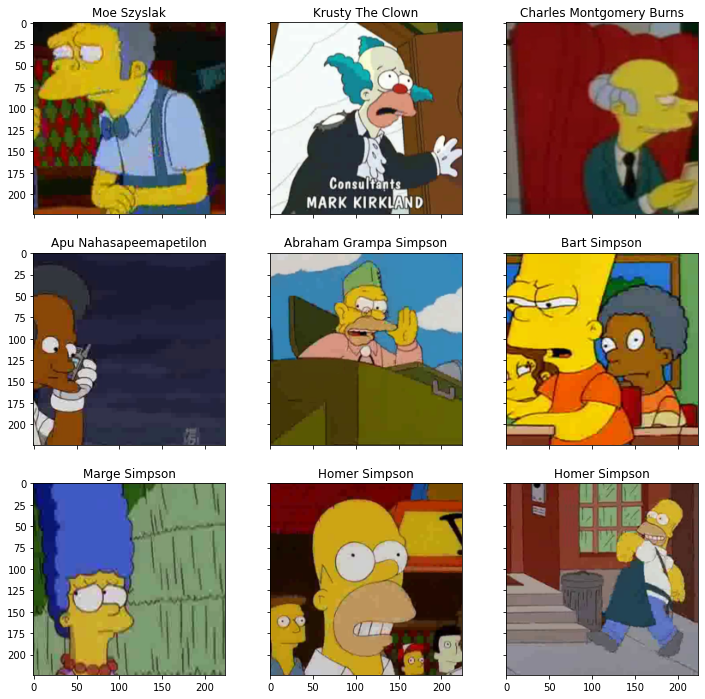

In [ ]:
sets = datasets(transforms_data)

rand_vis(sets['val'])

# Model and Training

## Learning from balanced data

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, num_labels)
model = model.to(DEVICE)

Loaded pretrained weights for efficientnet-b0


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

scheduler = optim.lr_scheduler.CyclicLR(optimizer, 
                                        base_lr=.001, 
                                        max_lr=.0025, 
                                        mode='exp_range', 
                                        gamma=0.99, 
                                        )
sampler = ImbSampler(sets['train'])

In [ ]:
# new augmentations for every cycle 
cycles = 5

for cycle in range(cycles):
    print(f'Cycle {cycle + 1}/{cycles}')
    loaders = dataloaders(transforms_data, sampler=sampler)
    model_balanced, metrics = train(
        model, loaders, criterion, optimizer, num_epochs=5)
    print('-' * 50)

Cycle 1/5
Epoch 1/5
--------------------------------------------------



train Loss: 3.2919; train Acc: 0.3189



val Loss: 2.8897; val Acc: 0.4721

Epoch 2/5
--------------------------------------------------



train Loss: 1.8368; train Acc: 0.7625



val Loss: 1.2062; val Acc: 0.8274

Epoch 3/5
--------------------------------------------------



train Loss: 0.7862; train Acc: 0.8869



val Loss: 0.6247; val Acc: 0.8836

Epoch 4/5
--------------------------------------------------



train Loss: 0.4496; train Acc: 0.9252



val Loss: 0.4205; val Acc: 0.9150

Epoch 5/5
--------------------------------------------------



train Loss: 0.3066; train Acc: 0.9441



val Loss: 0.3270; val Acc: 0.9296

Total training time: 20m 27s
Best Acc (validation): 0.929618
--------------------------------------------------
Cycle 2/5
Epoch 1/5
--------------------------------------------------



train Loss: 0.2356; train Acc: 0.9551



val Loss: 0.2861; val Acc: 0.9346

Epoch 2/5
--------------------------------------------------



train Loss: 0.1945; train Acc: 0.9646



val Loss: 0.2444; val Acc: 0.9438

Epoch 3/5
--------------------------------------------------



train Loss: 0.1510; train Acc: 0.9722



val Loss: 0.2230; val Acc: 0.9471

Epoch 4/5
--------------------------------------------------



train Loss: 0.1370; train Acc: 0.9743



val Loss: 0.2043; val Acc: 0.9503

Epoch 5/5
--------------------------------------------------



train Loss: 0.1234; train Acc: 0.9743



val Loss: 0.1857; val Acc: 0.9570

Total training time: 20m 23s
Best Acc (validation): 0.957006
--------------------------------------------------
Cycle 3/5
Epoch 1/5
--------------------------------------------------



train Loss: 0.1052; train Acc: 0.9793



val Loss: 0.1745; val Acc: 0.9575

Epoch 2/5
--------------------------------------------------



train Loss: 0.0954; train Acc: 0.9818



val Loss: 0.1651; val Acc: 0.9600

Epoch 3/5
--------------------------------------------------



train Loss: 0.0839; train Acc: 0.9845



val Loss: 0.1601; val Acc: 0.9621

Epoch 4/5
--------------------------------------------------



train Loss: 0.0739; train Acc: 0.9850



val Loss: 0.1515; val Acc: 0.9627

Epoch 5/5
--------------------------------------------------



train Loss: 0.0742; train Acc: 0.9845



val Loss: 0.1499; val Acc: 0.9634

Total training time: 20m 10s
Best Acc (validation): 0.963376
--------------------------------------------------
Cycle 4/5
Epoch 1/5
--------------------------------------------------



train Loss: 0.0662; train Acc: 0.9876



val Loss: 0.1417; val Acc: 0.9643

Epoch 2/5
--------------------------------------------------



train Loss: 0.0591; train Acc: 0.9884



val Loss: 0.1394; val Acc: 0.9659

Epoch 3/5
--------------------------------------------------



train Loss: 0.0584; train Acc: 0.9878



val Loss: 0.1354; val Acc: 0.9659

Epoch 4/5
--------------------------------------------------



train Loss: 0.0504; train Acc: 0.9907



val Loss: 0.1330; val Acc: 0.9666

Epoch 5/5
--------------------------------------------------



train Loss: 0.0494; train Acc: 0.9903



val Loss: 0.1289; val Acc: 0.9688

Total training time: 20m 8s
Best Acc (validation): 0.968790
--------------------------------------------------
Cycle 5/5
Epoch 1/5
--------------------------------------------------



train Loss: 0.0433; train Acc: 0.9913



val Loss: 0.1254; val Acc: 0.9689

Epoch 2/5
--------------------------------------------------



train Loss: 0.0412; train Acc: 0.9928



val Loss: 0.1246; val Acc: 0.9691

Epoch 3/5
--------------------------------------------------



train Loss: 0.0408; train Acc: 0.9925



val Loss: 0.1237; val Acc: 0.9696

Epoch 4/5
--------------------------------------------------



train Loss: 0.0382; train Acc: 0.9930



val Loss: 0.1201; val Acc: 0.9705

Epoch 5/5
--------------------------------------------------



train Loss: 0.0378; train Acc: 0.9934



val Loss: 0.1175; val Acc: 0.9709

Total training time: 20m 9s
Best Acc (validation): 0.970860
--------------------------------------------------


In [ ]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, f'{MODELS_DIR}/model_balanced.pth')

## Learning from imbalanced data

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, num_labels)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

scheduler = optim.lr_scheduler.CyclicLR(optimizer, 
                                        base_lr=.001, 
                                        max_lr=.0025, 
                                        mode='exp_range', 
                                        gamma=0.99, 
                                        )

In [ ]:
cycles = 5

for cycle in range(cycles):
    print(f'Cycle {cycle + 1}/{cycles}')
    loaders = dataloaders(transforms_data, sampler=None)
    model_imbalanced, metrics = train(
        model, loaders, criterion, optimizer, num_epochs=10)
    print('-' * 50)

In [ ]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, f'{MODELS_DIR}/model_imbalanced.pth')

# Prediction Visualization

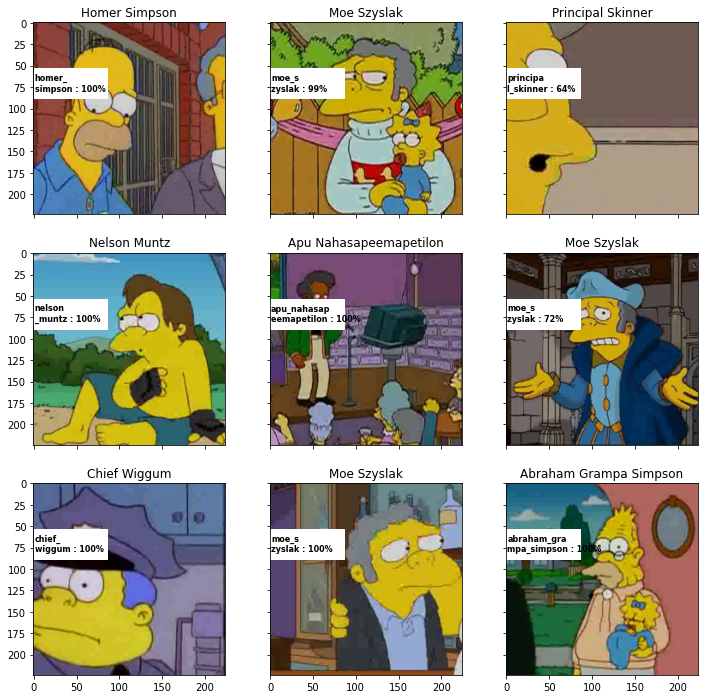

In [ ]:
rand_vis_preds(sets['val'], model_balanced)

# Averaging Predictions and Submit

## Averaging Models' Outputs

In [ ]:
probs_balanced = predict(model_balanced, sets['test'])
probs_imbalanced = predict(model_balanced, sets['test'])

In [ ]:
probs = (probs_balanced + probs_imbalanced) / 2

## Encoding Predictions and Submission

In [ ]:
label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))

preds = label_encoder.inverse_transform(np.argmax(probs, axis = 1))
test_filenames = [path.name for path in test_files]

In [ ]:
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
submit.to_csv('enet2_unbalanced.csv', index=False)